Fit score-based  generative model to 2d swiss roll data.

Code is taken from
https://jax.readthedocs.io/en/latest/notebooks/score_matching.html

Notebook author: Denis Mazur, edited by Just Heuristic, updated by [Saksham Rastogi](https://github.com/codeboy5)


In [127]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_swiss_roll


import jax
import jax.numpy as jnp

from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import optax  # Optimizers

from functools import partial

from IPython.display import clear_output

# Dataset

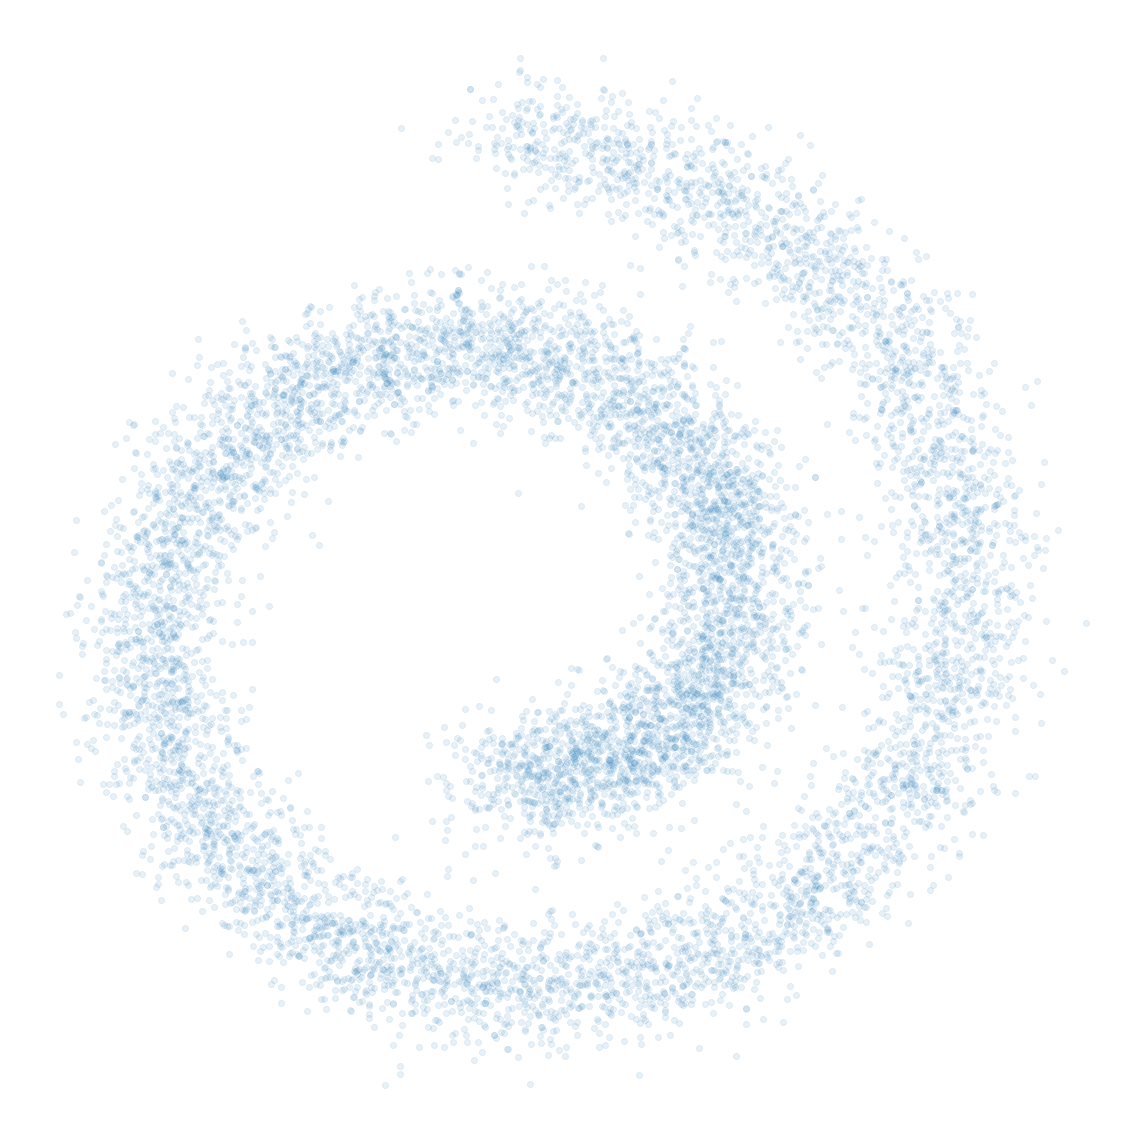

In [25]:
def sample_batch(size, noise=1.0):
    x, _ = make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return np.array(x)


plt.figure(figsize=[16, 16])
plt.scatter(*sample_batch(10**4).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("swiss_roll.png")

# Fit score function

In [26]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):

        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(2)(x)

        return x

In [27]:
@jax.jit
def compute_loss(params, inputs):
    #  a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(Model().apply, argnums=-1)

    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, {"params": params}))(
        inputs
    )  # [batch, dim, dim]

    trace_jacobian = jnp.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = jnp.square(Model().apply({"params": params}, inputs)).sum(axis=1)

    return jnp.mean(trace_jacobian + 1 / 2 * output_norm_sq)

In [28]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_loss(state.params, batch)
    grads = jax.grad(compute_loss, argnums=0)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [29]:
def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    net = Model()
    params = net.init(rng, jnp.ones([128, 2]))["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)

In [30]:
def train_loop(key, train_step, nsteps):
    key, subkey = jax.random.split(key)
    state = create_train_state(subkey, 1e-3)
    del subkey  # Must not be used anymore.
    loss_history = []
    for i in range(nsteps):
        x = sample_batch(size=128)
        key, subkey = jax.random.split(key)
        state, loss = train_step(state, x, subkey)
        loss_history.append(loss.item())

        if i % 200 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot(1, 2, 1)
            plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
            plt.scatter(jnp.arange(len(loss_history)), loss_history)
            plt.grid()

            plt.subplot(1, 2, 2)
            xx = jnp.stack(
                jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)),
                axis=-1,
            ).reshape(-1, 2)
            scores = Model().apply({"params": state.params}, xx)
            scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
            scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

            plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
            plt.xlim(-1.5, 2.0)
            plt.ylim(-1.5, 2.0)
            plt.show()

    return state

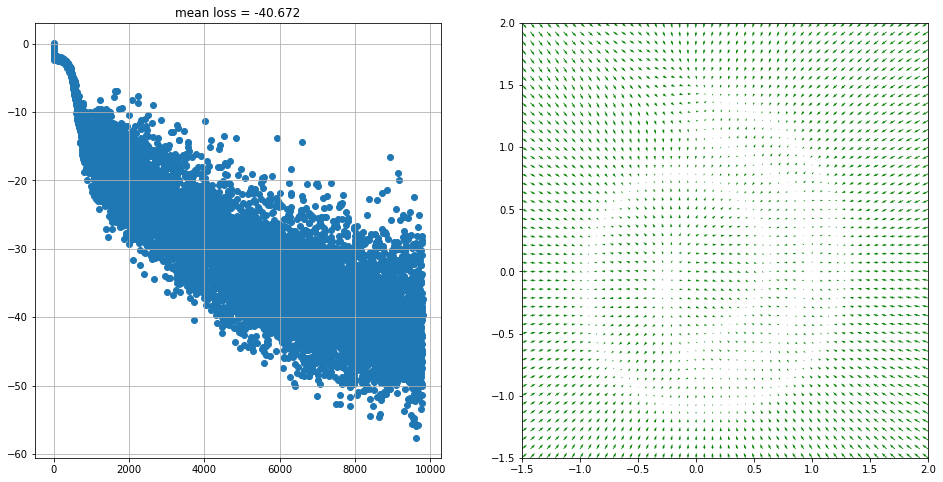

In [9]:
state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

In [10]:
state_basic = state

# Plot gradient field

In [11]:
state = state_basic

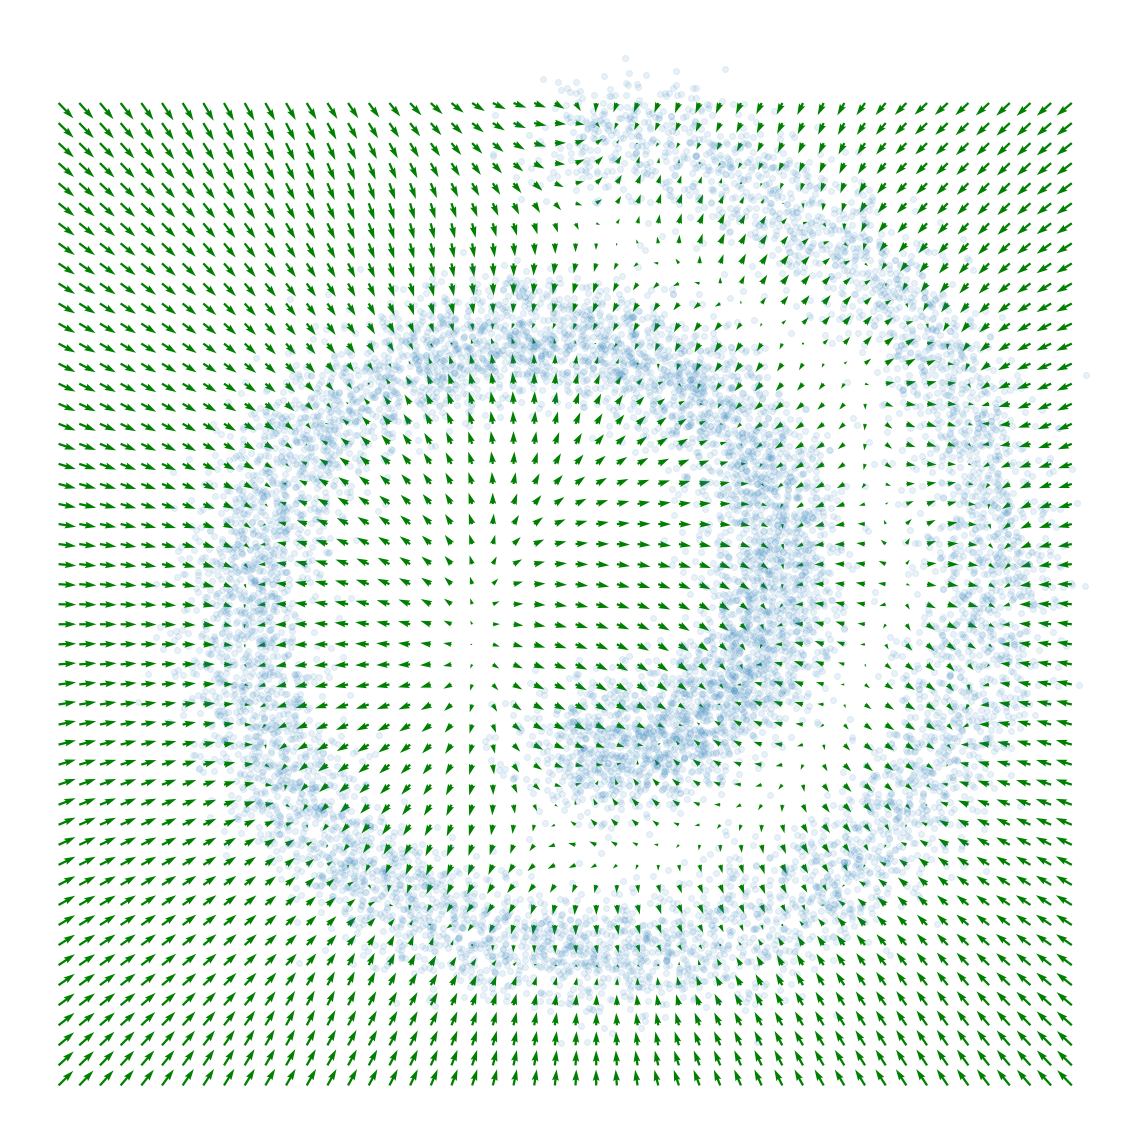

In [12]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll.png")

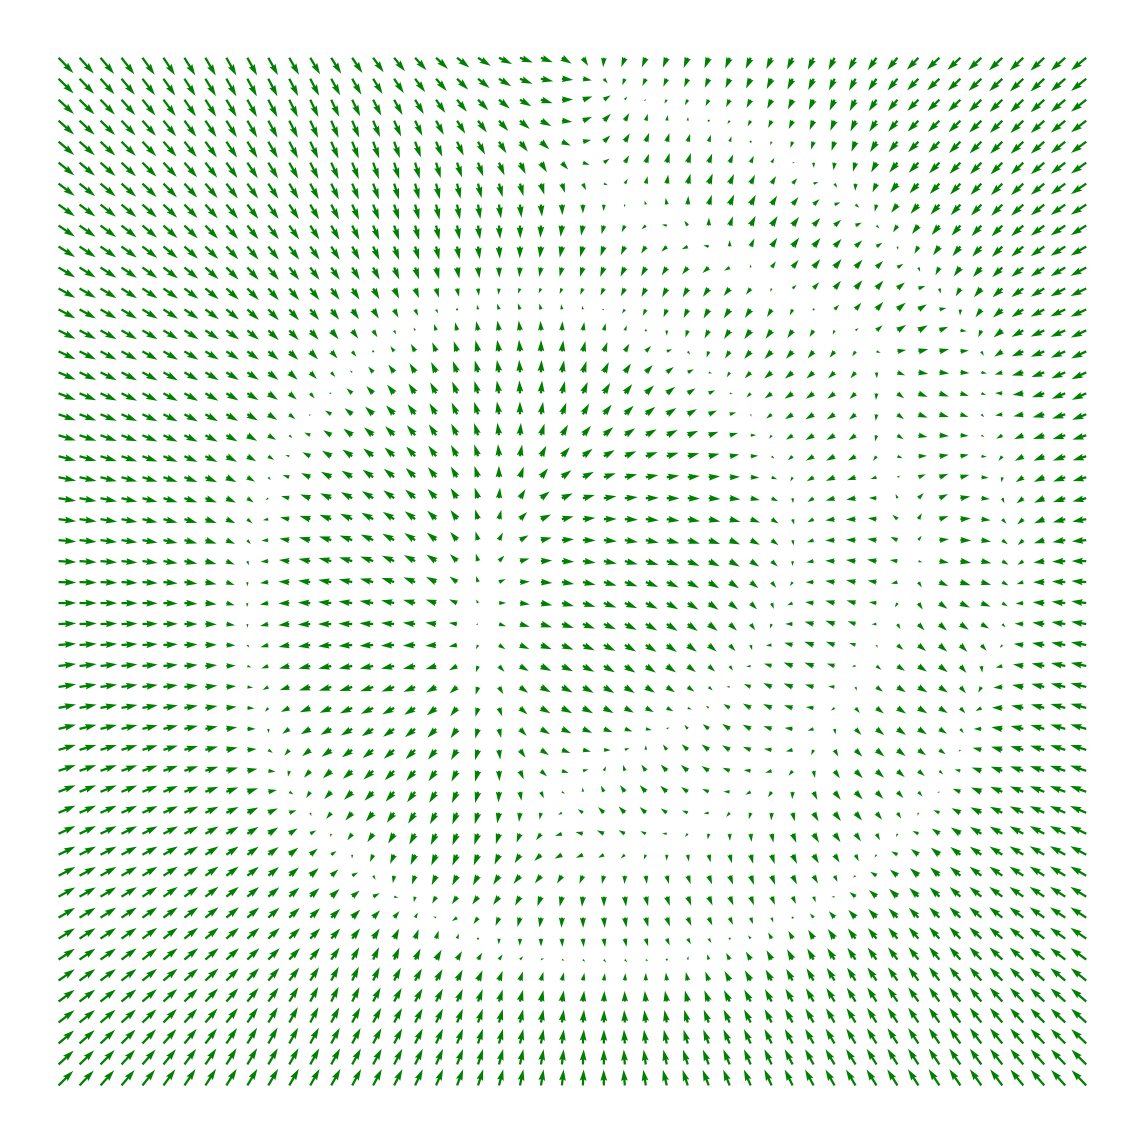

In [13]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
# plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll_no_data.png")

# Fit using Denoising Score matching (DSM)

$$D_F(q(\tilde x) \Vert p_\theta(\tilde x)) \simeq \sum^{N}_{i=1} [\frac{2}{\sigma} (z^{(i)})^⊤)\nabla_x log p_\theta (x^{(i)}) + \frac{\Vert z^{(i)} \Vert^2}{\sigma^2}] + constant$$

In [202]:
@jax.jit
def compute_dsm_loss(params, inputs, key):
    jacobian = jax.jacfwd(Model().apply, argnums=-1)
    apply = jax.jit(partial(Model().apply, {"params": params}))

    sigma = 1
    z = jax.random.normal(key, shape=inputs.shape) * sigma

    score = apply(inputs)

    return (
        1
        / 2
        * jnp.mean(
            2 / sigma * jnp.diagonal(z @ score.T)
            + jnp.square(z).sum(axis=1) / sigma**2
        )
    )

In [205]:
@jax.jit
def compute_dsm_loss(params, inputs, key):
    jacobian = jax.jacfwd(Model().apply, argnums=-1)
    apply = jax.jit(partial(Model().apply, {"params": params}))

    sigma = 1
    z = jax.random.normal(key, shape=inputs.shape)

    score = apply(inputs + sigma * z)

    return 1 / 2 * jnp.mean(jnp.square(z / sigma + score).sum(axis=1))

$$D_F(q(\tilde x) \Vert p_\theta(\tilde x)) = \frac{1}{2} \mathbb{E}_{q(x, \tilde x)}[\Vert s_\theta(\tilde x) + \frac{(\tilde x - x)}{\sigma^2} \Vert_2^2]$$

In [210]:
@jax.jit
def compute_dsm_loss(params, inputs, key):

    sigma = 1
    noise = jax.random.normal(key, inputs.shape) * sigma
    noised_inputs = inputs + noise

    score = Model().apply({"params": params}, noised_inputs)

    return 1 / 2 * jnp.mean(jnp.square(score + noise / sigma**2).sum(axis=1))

In [211]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_dsm_loss(state.params, batch, key)
    grads = jax.grad(compute_dsm_loss, argnums=0)(state.params, batch, key)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [212]:
state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

KeyboardInterrupt: ignored

# Fit using sliced score matching

In [14]:
@jax.jit
def compute_ssm_loss(params, inputs, key):

    apply = jax.jit(partial(Model().apply, {"params": params}))
    batch_dot = partial(jnp.einsum, "bu,bu->b")

    # generate random vectors from N(0, I)
    v = jax.random.normal(key, shape=inputs.shape)

    # predict score and compute jacobian of score times v
    score, jac_v = jax.jvp(apply, [inputs], [v])

    return jnp.mean(batch_dot(v, jac_v) + 1 / 2 * batch_dot(v, score) ** 2)

In [15]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_ssm_loss(state.params, batch, key)
    grads = jax.grad(compute_ssm_loss, argnums=0)(state.params, batch, key)
    state = state.apply_gradients(grads=grads)
    return state, loss

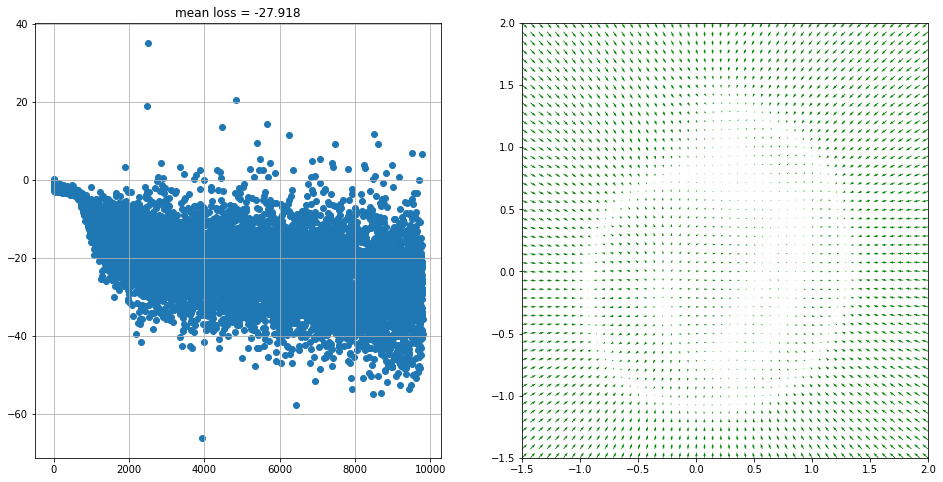

In [16]:
state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

In [17]:
state_basic = state

# Plot gradient field

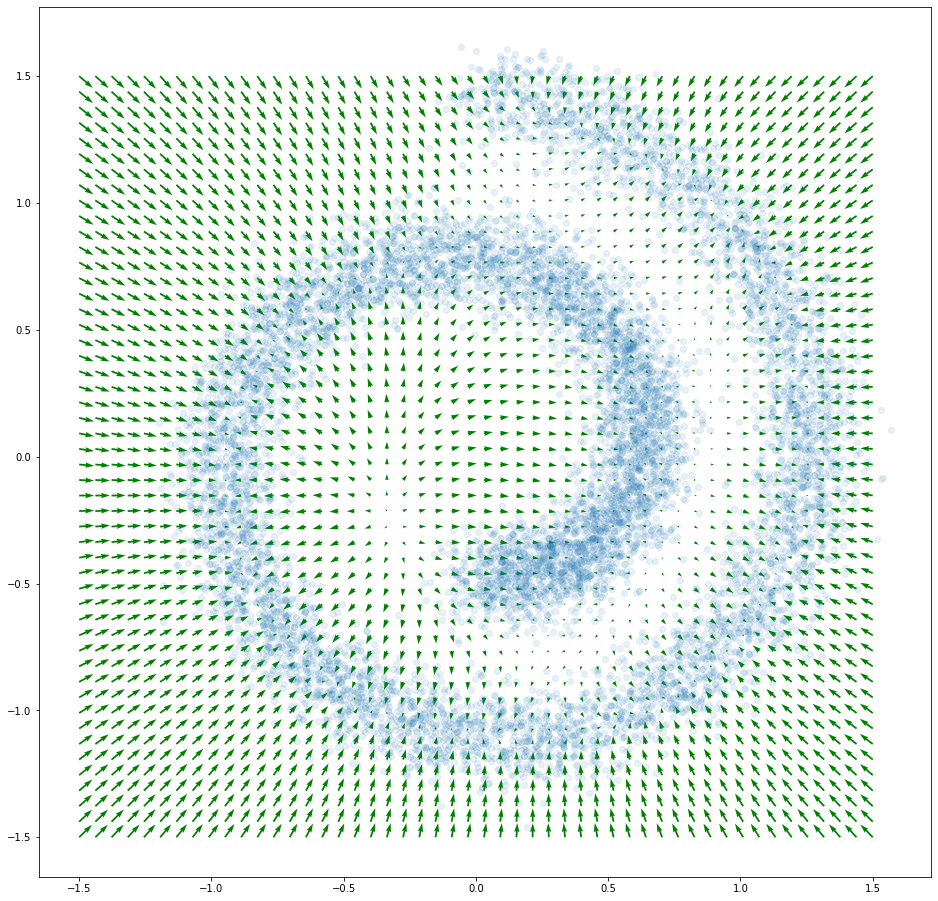

In [18]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.savefig("score_matching_sliced_swiss_roll.pdf", dpi=300)

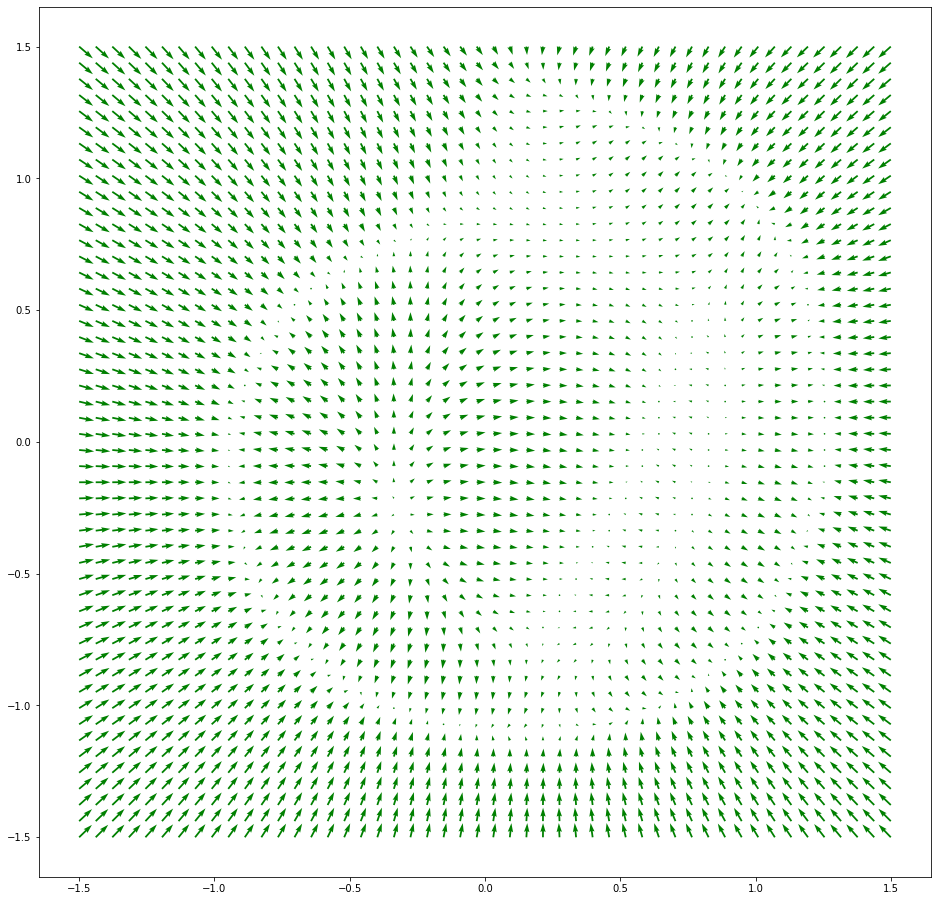

In [19]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
# plt.scatter(*sample_batch(10_000).T, alpha=0.1)

# Langevin sampling

In [20]:
def sample_langevin(
    x_initial, *, state, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0
):
    """sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t"""
    x_t, x_sequence = x_initial, [x_initial]

    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = (
            x_t
            + eps / 2 * Model().apply({"params": state.params}, x_t)
            + jnp.sqrt(eps) * temperature * z_t
        )
        x_sequence.append(x_t)
        eps *= eps_decay

    return jnp.stack(x_sequence)

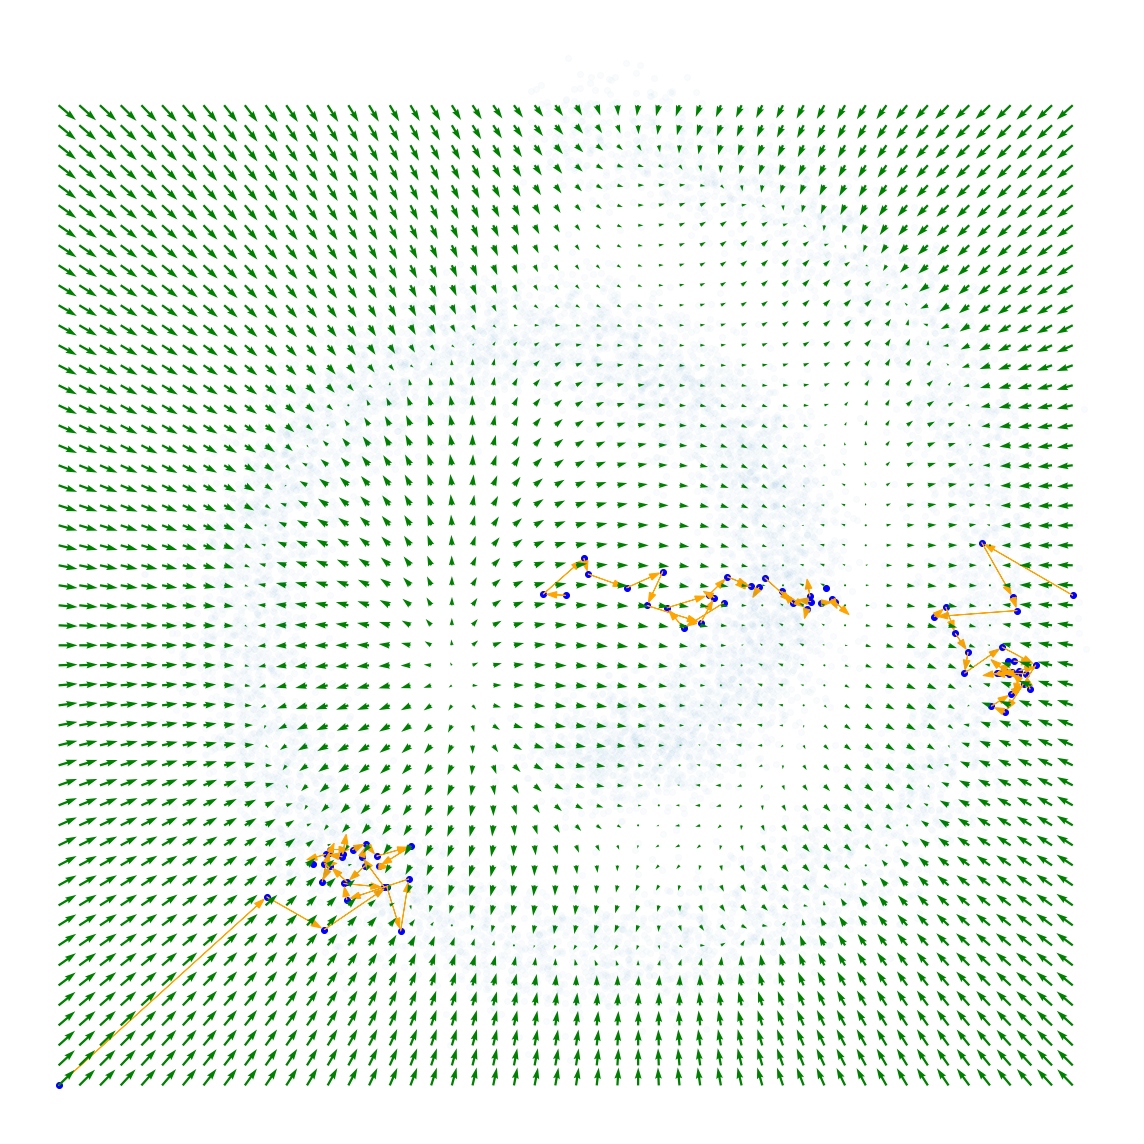

In [21]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)

for x_initial in jnp.array([[-1.5, -1.5], [0, 0], [1.5, 0]]):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, state=state_basic, num_steps=25)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = xx[1:] - xx[:-1]
    deltas = deltas - deltas / jnp.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(
            xx[i][0],
            xx[i][1],
            arrow[0],
            arrow[1],
            width=1e-4,
            head_width=2e-2,
            color="orange",
        )

# plot data points and gradients
plt.plot()
xx = jnp.stack(
    jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1
).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.axis("off")
plt.scatter(*sample_batch(10_000).T, alpha=0.025)
plt.tight_layout()
plt.savefig("langevin_swiss_roll.png")
plt.show()